<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
### Delete dataset exists
import os

folder_path = "./LITS17"
os.system(f"rm -rf {folder_path}")

0

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 115 (delta 52), reused 90 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (115/115), 17.18 KiB | 8.59 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
from kltn.init.install_dependencies import install_packages
install_packages("./kltn")


In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS()

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 2) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
2.00% complete (down: 27238.1 kB/s up: 805.2 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[17

## Load data

In [5]:
source_folder = "/content/LITS17"
full_train_dataset, val_dataset = get_datasets_lits(source_folder=source_folder, seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [6]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [7]:
for batch in train_loader:
    # Assuming your input data is a 4D tensor (batch_size, channels, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 519, 512, 512])
Label shape in the first batch: torch.Size([1, 519, 512, 512])


## Visual data

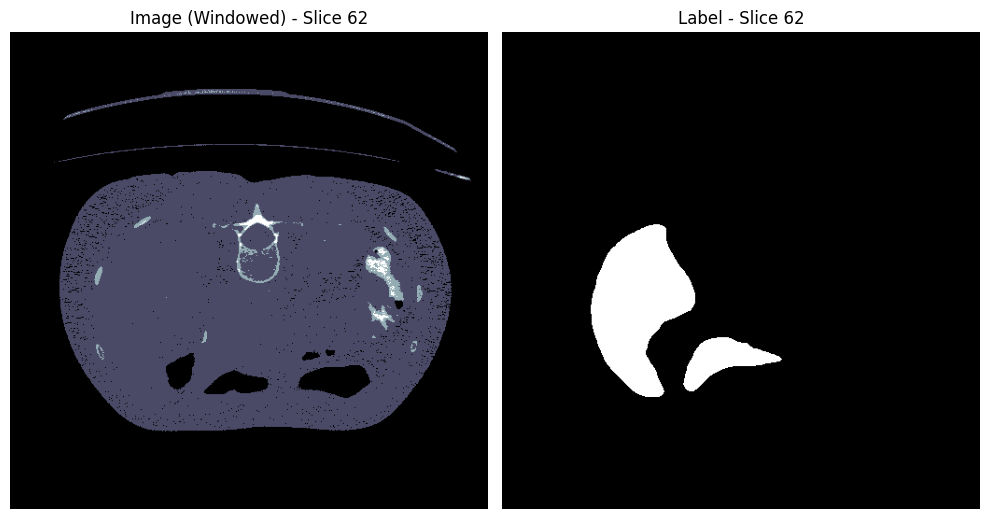

In [28]:
for batch in train_loader:
    image_sample = batch['image']
    label_sample = batch['label']

    slice_idx = image_sample.shape[1] // 2  # Lấy lát cắt giữa

    img_slice = image_sample[0, slice_idx, :, :].numpy()
    label_slice = label_sample[0, slice_idx, :, :].numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image (Windowed) - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap="gray")  # Hiển thị ground truth
    axes[1].set_title(f"Label - Slice {slice_idx}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    break  # Chỉ hiển thị batch đầu tiên

